# Project 1: Assembling Genes

   <div class="alert alert-block alert-danger">
    <center>Due: <b>Monday, September 5, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    
For this assignment, you are encouraged to work with one other person satisfying the constraints from Class 2. 
You are permitted (actually _encouraged_) to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from previous semesters of this course, or from any other students in the class (other than your collaboration with your partner), and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>

Team Members (Names):  Syed Ahmad

Team Member UVA Computing IDs:sba5k

</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
    
External Resources Used:

</div>

In this project, we will explore genome assembly—the process of determining the order of nucleotides in DNA from fragmented reads. As you might have studied in the reading assignments, genome assembly can get quite complicated, as problems such as full sequence coverage, finding a good length for reads (the $k$ in $k$-mer), and sequencing errors present challenges for sequencing analysis and accuracy. You can assume perfect coverage for all parts of the assignment and no read errors for the first two questions.


<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: <a href="https://forms.gle/rNTXfYojTLEQ8idg6"><em>https://forms.gle/rNTXfYojTLEQ8idg6</em></a>. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name <i>uvaid1\_uvaid2.ipynb</i> (where <i>uvaidn</i> is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm (EST) on Monday, September 5.

## Install basic required packages.

- Install basic required packages, should be run only once. You may need to restart the kernel after this stage.
- Make sure you have [graphviz](https://graphviz.org/download/) installed on your system.
- The second cell adds Graphviz to your path, you may have to change based on where the install folder is.

<b>NOTE: We provide utils.py, which may contain helpful functions for you to use, as well as gvmagic.py, which is a deprecated package to use graphviz within the notebook</b>

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

## Genome Assembly

For this part, you're given reads generated while trying to sequence the DNA of a TeleTubby (some unknown organism) with a \textit{very} small genetic code. By answering the following questions, you will learn how to assemble the original genome sequence from sequence reads.

Sequencing data is often stored in FASTQ file format. In TeleTubby.fastq, you will find the data organized in a particular order that repeats every four lines. The first line contains the metadata that encodes the name of the read, the experiment type, the kind of sequencing machine used, etc. The second line is the sequence of bases. The third line functions as a placeholder line. The fourth line is a sequence of base qualities that encode the qualities for the corresponding bases in the sequence line. We will only work with the sequence and quality score lines in this question.

In [3]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import utils
from tqdm import tqdm

#### Question 1.1.1 GC-content

The GC-content (or the ratio of G and C nucleotides) is related to the melting temperature of the DNA double helix. Use the following equation to calculate the melting temperature of DNA for TeleTubby $t_m$ in Celsius:

\begin{equation*}
t_m = 64.9+0.41(\%GC)-\frac{500}{\text{length of sequence}}
\end{equation*}

As a reference, the human genome is known to have between 35%-60% GC-content. 

In [4]:
# Read sequence reads (error-free) from file
sequence_reads, qualities = utils.read_fastq('TeleTubby.fastq')
# print(sequence_reads)
store = collections.Counter([x for i in sequence_reads for x in i])
# Calculate %GC content
gc = ((store['C']+store['G'])/(store['C']+store['G']+store['A']+store['T']))*100
print("%GC content:",gc)
# Print out temperature in Celsius
total_len = 0
for i in sequence_reads:
    total_len += len(i)
# print(total_len)
t = 64.9 + (0.41*gc)-(500/(total_len))
print("Temperature:",t)

%GC content: 47.95221843003413
Temperature: 84.34709897610922


#### Question 1.1.2 Interpreting quality scores

Phred33 quality scores are represented as the character with an ASCII code equal to its value + 33 (to make them easy to print alongside genome sequences). List the top 5 most frequent scores in ASCII symbol as well as their Phredd33 scores in TeleTubby.fastq. You can refer to the [official Illumina website](https://support.illumina.com/help/BaseSpace_OLH_009008/Content/Source/Informatics/BS/QualityScoreEncoding_swBS.htm) to reference the scoring encoding.

What is the average Phred33 score in TeleTubby.fastq?

In [5]:
store_quality = collections.Counter([x for i in qualities for x in i])
# print(store_quality)
count = 0
score = 0
for letter in store_quality.keys():
    q = ord(letter) - 33
    score += q*store_quality[letter]
    count +=(1*store_quality[letter])
print("Average Phred33 score in TeleTubby.fastq:", score/count)
# Calculate and print average Phred33 score
qual = (store_quality.most_common(5))
print("ASCII:FREQ")
for i in qual:
    print(i[0],":",i[1] , "Phredd33:", ord(i[0])-33,)

Average Phred33 score in TeleTubby.fastq: 34.476535836177476
ASCII:FREQ
5 : 96 Phredd33: 20
? : 95 Phredd33: 30
D : 95 Phredd33: 35
K : 90 Phredd33: 42
F : 88 Phredd33: 37


#### Question 1.1.3 Frequency analysis

Looking at repetitions in the sequence can be helpful in estimating the "redudancy" in the organisms. Humand and other evolved animals have a lot of redundancy, while smaller organisms like bacteria have highly packed genomes. One heuristic to estimate this before actually performing the assembly could be looking at how often certain $k$-mers are repeated.

<b>Print out the 3 most frequent k-mers with their frequencies</b>

In [6]:
com = collections.Counter([i for i in sequence_reads])
print("3 Most Common:", com.most_common(3))

# Find and print out the three most repeated k-mers and their frequencies

3 Most Common: [('GCTATCGC', 3), ('CGCTATCG', 2), ('TATCGCAA', 2)]


### Question 1.2. Greedy approach

One of the approaches to assemble the genome from the given reads is a greedy algorithm. Have a look at the greedy algorithm described on [Wikipedia](https://en.wikipedia.org/wiki/Sequence_assembly#Greedy_algorithm) and answer the following.

#### Question 1.2.1 What would the runtime be of this algorithm, given $n$ $k$-mer reads?

<i>Answer</i>: It will require n^2, alignment will require n^2 time with a double for loop with n time to merge the best overlap.

#### Question 1.2.2 Would this algorithm always yield a unique solution?

<i>Answer</i>: This algorithm will not always provide a unique solution. In the case where there are 2 equally optimal merges the algorithm could do and get an equally optimal/"right" solution, there would be more than 1 solution to the inputs of the algorithm.

#### Question 1.2.3 Would this algorithm always yield the <i>right</i> solution?

<i>Answer</i>: The greedy approach will always yield the right solution even if it is not the best solution and most optimal solution. The Wikipedia page here (https://en.wikipedia.org/wiki/Greedy_algorithm) says it can produce the "unique worst possible". This is helpful because it will allow it to give us a solution in a short amount of time rather then going through all possible iterations.

### Question 1.3 Graph-based approaches

Graphs for genome assembly can be constructed in two ways:

- de Bruijn graph: Processing $k-$mers as nodes, with $(k-1)-$mers as edges, and
- Overlap graph: Processing $k-$mers as edges, with $(k-1)-$mers as nodes.

de Bruijn graphs can be processed to find Euler paths, while Overlap graphs can be processed to find Hamiltonian paths. Both of these are valid ways to reconstruct the original genome.

<b>Use one of these two techniques to reconstruct the sequence, and print out your reconstructed sequence. Which method did you pick out of the two, and why? (hint: imagine what would happen when we have millions of reads). Use the k-mers provided in TeleTubby.fastq</b>.

We provide some skeleton code that you may use, but you may also come up with your own solution.

In [7]:
# Read reads into graph
# de bruijn graph - list items as nodes and (k-1)-mers as edges. For a huge list overlap would be bad since there would be n*(len(l))
def build_graphbad(k_mers):
    k = len(k_mers[0])
    edges = []
    nodes = set()
    # Your code here
    for kmer in k_mers:
# #         edges.append(kmer)
        edges.append((kmer[0:k-1],kmer[1:k]))
        nodes.add(kmer[0:k-1])
        nodes.add(kmer[1:k])
    return nodes, edges
def build_graph(kmers):
    k = len(kmers[0])
    graph = {}
    for i in range(len(kmers)):
        try:
            graph[kmers[i][:-1]].append(kmers[i][1:])
        except:
            graph[kmers[i][:-1]] = [kmers[i][1:]]
    return graph

def get_key(seq_r):
    lpos = len(seq_r[0])-2     
    i=0            
    tot_iadj = len(seq_r)
    pos =1
    try:
        while (1<tot_iadj):
            ia = seq_r[i]
            end_ia = ia[pos:len(ia)]
            match=False
            for j,ja in enumerate(seq_r):
                sta_ja = ja[0:len(ia)-pos]
                if (end_ia==sta_ja and ja != ia and len(end_ia)>lpos):
                    seq_r.remove(ja)
                    seq_r.remove(ia)
                    seq_r.append(ia +  ja[len(sta_ja):len(ja)])
                    i=-1
                    tot_iadj = len(seq_r)
                    match=True
                    pos = 1
                    break
            if(not match):
                pos+=1
                if (len(end_ia)==0):
                    i+=1
                    pos=1
            else:
                i+=1
        for i,d in enumerate(seq_r):
           print(d)
    except:
        index = 0
        max_len = 0
        for i in range(len(seq_r)):
            if len(seq_r[i]) > max_len:
                index = i
                max_len = len(seq_r[i])
        key1 = seq_r[index][:lpos+1]
        return key1
        
graph = build_graph(sequence_reads)
key1 = get_key(sequence_reads)
# index = 0
# max_len = 0
# for i in range(len(zz)):
#     if len(zz[i]) > max_len:
#         index = i
#         max_len = len(zz[i])
# key1 = zz[index][:7]

In [8]:
# Implement assembly algorithm
# print(find_eulerian_tour(graph))
def EulerCycleSolve1(graph, the_key=""):
    path = []
    key = ""
    if the_key == "":
        key = np.random.choice(list(graph.keys()))
    else:
        key = the_key
    while len(graph[key]) == 0:
        key = np.random.choice(list(graph.keys()))
    path.append(key)
    while len(graph.values()) != 0:
        value = np.random.choice(graph[key])
        graph[key].remove(value)
        key = value
        path.append(key)

        while len(graph.keys()) != 0 and key not in graph.keys():
            key = np.random.choice(list(graph.keys()))
        while len(graph[key]) == 0:
            if len(graph.keys()) <= 1:
                return path
            graph.pop(key)
            key = np.random.choice(list(graph.keys()))
    return path

In [9]:
# Print assembled sequence
# print(assemble(nod,edg))
# def assembledSequenceMaker(path):  
#     s = path[0]
#     for i in range(1, len(path)):
#         s += path[i][-1]
#     return s
complete = EulerCycleSolve1(graph,key1)
# sequence = assembledSequenceMaker(full)# s = euler[0]
def assembledSequenceMaker(complete):
    
    seq = complete[0]
    for i in range(1, len(complete)):
        seq += complete[i][-1]
    return seq

seq = assembledSequenceMaker(complete)
print(seq)
print(len(seq))

# for i in range(1,len(euler)):
#     s += euler[i]
# print(s)
# print(sequence)

TACGCCAAATAGCAATGCGCAGGATAACAACTTATGTACTACATGTTGTTTCTCGTGCCCGCCAATGTCGAGAGATTTGTGCTATCGCTGCCCGGAGGCGCTATCGCAAACCGACTGTCGGACTCTTTCATGAGCAAAAAAAGTGGGAGTATGGTGCACATCCGCTATCGCAACCTAAGAGAGAAGGGGTTTTGTGTTAGCAGTTTCTTCATGCATCTCTTTACAAGAATTACAGGAGCCAAACACTCGCTGTCATGGTATCGACATATCGCTACTGGTGCCGCCCTTCGATGCAATGTT
300


In [10]:
# Needed to properly visualize graphs
%load_ext gvmagic

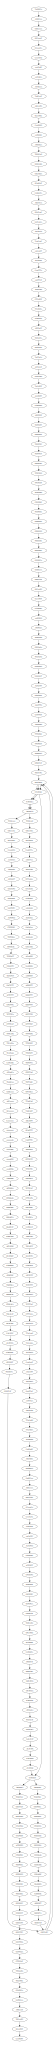

In [11]:
# Helper function to visualize de Bruijn graphs
node_func=[]
edge2 = collections.defaultdict(list)
edgesss = []
for each in range(0,len(complete)-1):
    edgesss.append((complete[each],complete[each+1]))
#     edge2[complete[each]].append(complete[each+1])
    node_func.append(str(complete[each]+complete[each][-1]))

# edges_bruijn = edgesss
# nodes_bruijn = node_func
# print(get_first(node_func))
# print (*(sorted([key + ' -> ' + ','.join(sorted([v for v in value]))
#                  for key, value in edge2.items()])),sep ='\n')
# print(len(edges_bruijn))
# print(edges_bruijn)
# print(len(node_func))
# for i in complete
# print(edges_bruijn)  
# print(edgesss)
%dotstr utils.viz_debruijn(node_func,edgesss)
                    
# %dotstr utils.viz_debruijn(nodes_bruijn, edges_bruijn)

In [12]:
# Main assembly algorithm

def assemble_sequence(seq):
    assembled_sequence = seq
    # Your code here
    return assembled_sequence

In [13]:
# Output assembled sequence

assmebled_seq = assemble_sequence(seq)
print(assmebled_seq)

TACGCCAAATAGCAATGCGCAGGATAACAACTTATGTACTACATGTTGTTTCTCGTGCCCGCCAATGTCGAGAGATTTGTGCTATCGCTGCCCGGAGGCGCTATCGCAAACCGACTGTCGGACTCTTTCATGAGCAAAAAAAGTGGGAGTATGGTGCACATCCGCTATCGCAACCTAAGAGAGAAGGGGTTTTGTGTTAGCAGTTTCTTCATGCATCTCTTTACAAGAATTACAGGAGCCAAACACTCGCTGTCATGGTATCGACATATCGCTACTGGTGCCGCCCTTCGATGCAATGTT


## Question 2 - Sequencing SARS-CoV-2 virus

Let's move on from TeleTubbies to real-world organisms. Let's start small- with a variant of the SARS-CoV-2 virus. You're given reads from <i>actual</i> genome sequencing runs in the SARS-CoV2.fastq file provided.

Repeat Question 1.3 on this data. You can re-use your implementation and simply run it on the new data. Print out your reconstructed sequence to a file "output.txt". For this part, we will still assume that all the reads are error-free. Set $k=25$.

In [14]:
# Read sequence reads
sequence_reads_covid, qualities_covid = utils.read_fastq('SARS-CoV2.fastq')

In [15]:
# Read reads into graph
graph = build_graph(sequence_reads_covid)

In [16]:
# Call main assembly algorithm
assmebled_covid_seq = EulerCycleSolve1(graph)

In [17]:
# Write assembled sequence to file

assmebled_seq = assembledSequenceMaker(assmebled_covid_seq) # Use your assembled genome
with open("covid_overlap.txt", "w") as f:
    f.write(assmebled_seq)

# Question 3- Error-Aware Assembly (Extra Credit)

In the parts above, we assumed error-free reads while assembling $k$-mers. As much as we'd like that, actual reads can (and do) have errors, captured by their Phred scores. For this question, you're given raw, actual reads from sequencing runs (download reads here: https://sra-pub-sars-cov2.s3.amazonaws.com/sra-src/SRR11528307/ABS2-LN-R1_cleaned_paired.fastq.gz).  Given these reads and their Phred33 scores, can you assemble the genome?

<b>Print out your assembled sequence, along with a brief explanation of how your algorithm works</b>

This is an open-ended question. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have, in the cells below.